# Modulo principal, já temos a base de dados Amostra pronta, e farei a a mineiração dos dados dos campos necessários para executar o Modelo de Previsão de Seerie Temporais, o Prophet:
## 1) Campo Data da Aplicação da Vacina ('ds')
## 2) Campo Data Descricao Dose 1. Dose e 2. Dose ('y')

In [1]:
# DATA de Atualização; 29/5/2021

In [1]:
# Importando as principais Bibliotecas:

import csv
import time
import requests 
import pandas  as pd
import seaborn as sns
from random   import random
from prophet  import Prophet
from datetime import datetime
from datetime import date


# Importar bibliotecas para construir gráficos:

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Bibliotecas de Algoritmos de Regressão:

from sklearn.tree            import DecisionTreeClassifier
from catboost                import CatBoostClassifier
from sklearn.metrics         import accuracy_score
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing   import StandardScaler
from sklearn.ensemble        import RandomForestRegressor, ExtraTreesRegressor


# Biblioteca do Prophet para Algoritmo de Previsão:

from prophet      import Prophet
from prophet.plot import plot_plotly
from prophet.plot import plot_components_plotly
from prophet.plot import add_changepoints_to_plot


# Leitura Banco Dados da Amostra no dia 26/05/2021:

df = pd.read_csv("BD_Amostra-Alguns-26-05-2021.csv", sep=";")
usecols   = ['vacina_fabricante_nome',
             'paciente_idade',
             'paciente_id',
             'vacina_dataAplicacao',
             'paciente_endereco_uf',
             'vacina_descricao_dose']



In [2]:
# Definindo Variaveis Globais:

FATOR_AMOSTRA = 0.001 # É o valor da porcentagem obtida pelo Banco de Dados Amostra: 1/1000

# Primeiro passo: 

## Preparando o campo para o datetime: formato = %Y-%m-%dT%H:%M:%S"
## Denifir que o campo 'vacina_dataAplicacao' terá somente a DATA no formato: AAAA/MM/DD
## Remover o TimeZone do campo DATA


In [3]:
# converter a coluna datetime  somente em date

df['vacina_dataAplicacao'] = pd.to_datetime(df['vacina_dataAplicacao']).dt.date


df.dtypes


vacina_fabricante_nome    object
paciente_idade             int64
paciente_id               object
vacina_dataAplicacao      object
paciente_endereco_uf      object
vacina_descricao_dose     object
dtype: object

In [4]:

df['vacina_dataAplicacao']

0        2021-03-19
1        2021-03-03
2        2021-03-09
3        2021-04-01
4        2021-03-25
            ...    
61473    2021-05-25
61474    2021-05-07
61475    2021-05-25
61476    2021-05-25
61477    2021-05-25
Name: vacina_dataAplicacao, Length: 61478, dtype: object

# Segundo Passo: 
## Tratando do campo "vacina_descricao_dose" teremos os seguintes casos:
##   - Primeira Dose 
##   - Segunda Dose após um intervalo definido
##   - Dose única

In [5]:

df["vacina_descricao_dose"].unique()

array(['\xa0\xa0\xa0\xa01ª\xa0Dose', '\xa0\xa0\xa0\xa02ª\xa0Dose',
       '1ª Dose', '2ª Dose', 'Única'], dtype=object)

In [7]:
# Note que o conteúdo do campo "data_descricao_dose" contém os caracteres:

# array(['\xa0\xa0\xa0\xa01ª\xa0Dose', 
#        '\xa0\xa0\xa0\xa02ª\xa0Dose']
#        '1ª Dose', '2ª Dose', 'Única'



In [6]:
# Tratando o campo "vacina_descricao_dose":

# 1) Transformando todos as linhas como Minuúsculas
# 2) Quando aparecer Null (NaN) substitui-se por "-"
# 3) Tratando todos os caracteres ASCII 

df["vacina_descricao_dose"] = (df["vacina_descricao_dose"]
                                 .str.lower()
                                 .str.normalize("NFKD")
                                 .str.lstrip()
                                 .str.replace(" ","_")
                                 .str.encode("ascii", errors="ignore")
                                 .str.decode("utf-8"))

# Terceiro Passo: 

## Vou tratar o campo 'vacina_descricao_dose':

## Teremos 3 situações para contabilizar o número de vacinas tomadas:
##  (1) A Primeira Dose ==> 1a_dose
##  (2) A Segunda Dose  ==> Totalmente vacinados com a  2a_dose
##  (3) Ser Dose Unica!!

In [9]:
# A dose unica aparece como valor = 1

# OBS: A vacina Jassen da Johnson&Johnson é somente 1 Dose
# df.loc[df["vacina_descricao_dose"] == 'unica', "vacina_descricao_dose" ] =  '1a_dose'

In [7]:

df["vacina_descricao_dose"].value_counts()

1a_dose    42101
2a_dose    19376
unica          1
Name: vacina_descricao_dose, dtype: int64

# Quarto Passo:

## Usando a função: Get_Dummies para descrever o campo 'vacina_descricao_dose':

## se não tomou vacina da 1ª Dose' = 0, se tomou a 1ª Dose' = 1
## se não tomou vacina da 2ª Dose' = 0, se tomou a 2ª Dose' = 1



In [8]:

dummies = df["vacina_descricao_dose"].str.get_dummies("\n")

In [9]:
# Concatenar com o DataFrame e a coluna Dummies:

df = pd.concat([df, dummies], axis = 1)

In [10]:
dummies.head(5)

,1a_dose,2a_dose,unica
0,1,0,0
1,0,1,0
2,1,0,0
3,1,0,0
4,1,0,0


# Fazendo o cálculo para valores com o FATOR_AMOSTRA

In [11]:
Vacinados_uma_dose = df['1a_dose'].sum()

print('Total REAL de Vacinados com 1. dose = ', Vacinados_uma_dose/FATOR_AMOSTRA)

Total REAL de Vacinados com 1. dose =  42101000.0


In [12]:
Vacinados_duas_doses = df['2a_dose'].sum()

print('Total REAL de Vacinados com 2. dose = ', Vacinados_duas_doses/FATOR_AMOSTRA)

Total REAL de Vacinados com 2. dose =  19376000.0


In [13]:
# Limpando os campos das Doses, retirando os nulos NaN

df['1a_dose'].fillna(0, inplace = True)

df['2a_dose'].fillna(0, inplace = True)

<AxesSubplot:xlabel='count', ylabel='vacina_descricao_dose'>

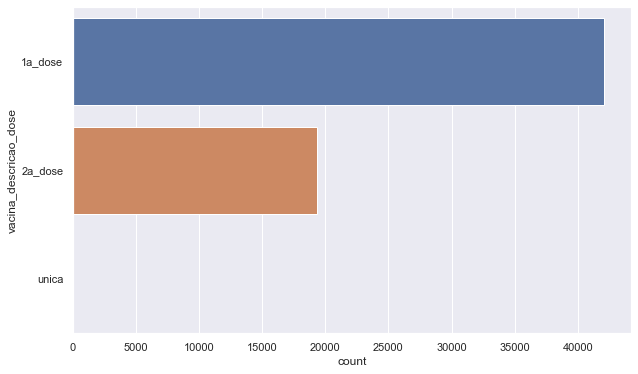

In [14]:
plt.figure(figsize = (10,6))
sns.countplot(data = df, y = "vacina_descricao_dose")

# Quinto Passo: 

## Trabalhando com informações da '1a_dose' para rodar a PREVISAO:

In [15]:
df1 = df.groupby('vacina_dataAplicacao').agg({'1a_dose':'sum'}).reset_index()

df1['vacina_dataAplicacao'].value_counts()

2021-03-17    1
2021-01-24    1
2021-03-27    1
2021-03-05    1
2021-03-19    1
             ..
2021-05-10    1
2021-01-30    1
2021-02-26    1
2021-04-16    1
2021-05-19    1
Name: vacina_dataAplicacao, Length: 129, dtype: int64

# Sexto Passo: 

# O Algoritmo do Prophet para Previsao Séries Temporais: 
# dois campos importantes 'ds' e 'y', onde:
## ds => é a coluna DATA e já está no formato de AAAA-MM-DD

## A coluna y => deve ser numérica e representa a medida que desejamos prever:

## Aqui vou separar em duas etapas as previsões: 
## y = 1.dose total da para dataframe ==> df1 
## y = 2.dose para dataframe          ==> df2

In [ ]:
# A primeira etapa será previsão da 1.dose 

In [16]:
# Renomeando as colunas para preparar para rodar o Modelo Prophet:

df1.columns = ['ds', 'y']

In [17]:
df1.head(3)

,ds,y
0,2020-03-23,3
1,2021-01-18,3
2,2021-01-19,68


In [22]:
# Plotting the TIme Series Data

<AxesSubplot:title={'center':'Tempo Data Series'}, xlabel='ds'>

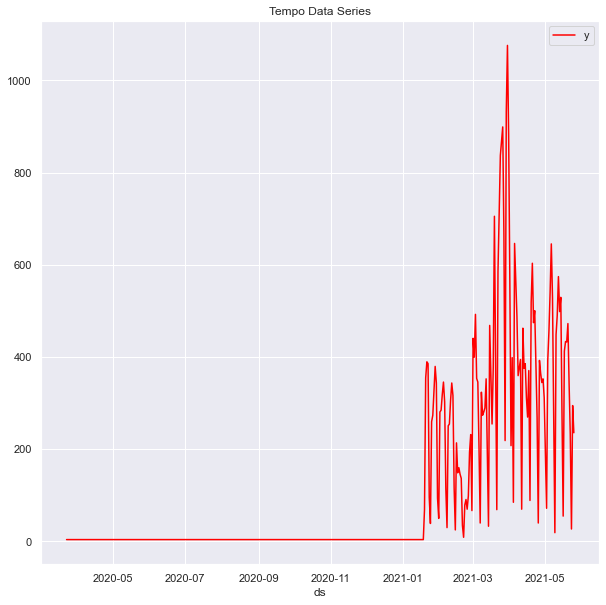

In [18]:
df1.plot(x ='ds', y ='y', figsize = (10,10), title = 'Tempo Data Series' , color = 'red')

# Sétimo Passo: 
## Definifindo a sazonalidade dos períodos: diario, mensal, anual ou quinzenal:

In [19]:
# Definindo a sazonalidade diaria, semanal e mensal terá mais controle sobre a sazonalidade. 



model = Prophet(daily_seasonality      = False,
               weekly_seasonality      = False,
               yearly_seasonality      = False,
               ).add_seasonality(name= 'mounthly',
                                 period = 30,
                                 fourier_order = 12
                ).add_seasonality(name = 'dayly',
                                 period = 1,
                                 fourier_order = 15
                                 ).add_seasonality(name = 'weekly',
                                 period = 7,
                                 fourier_order = 20,
                ).add_seasonality(name= 'yearly',
                                 period = 365.25,
                                 fourier_order = 20
                ).add_seasonality(name= 'quartely',
                                 period = 365.25/4,
                                 fourier_order = 5,
                                 prior_scale = 15)
                

# Finalizando:

## Definindo parâmetros do Prophet(), assegurando que teremos a previsão positiva:


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


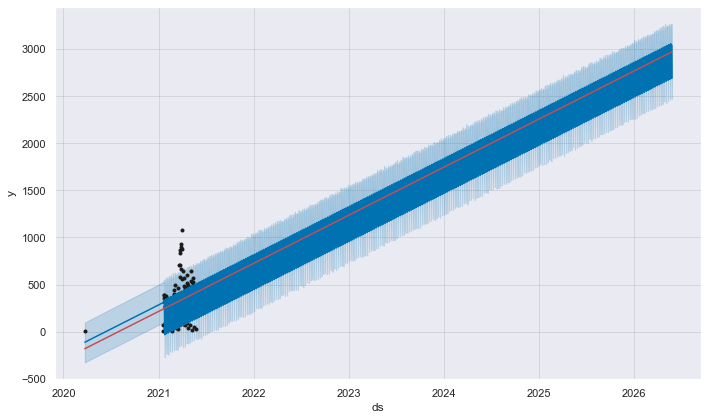

In [20]:
# Fazendo Saturações Previsões de Crescimento:

model = Prophet()

model.fit(df1)

future   = model.make_future_dataframe(periods = 1826)

forecast = model.predict(future)

fig1 = model.plot(forecast)

a = add_changepoints_to_plot(fig1.gca(), model, forecast)

<AxesSubplot:title={'center':'Atual x Previsão'}, xlabel='ds'>

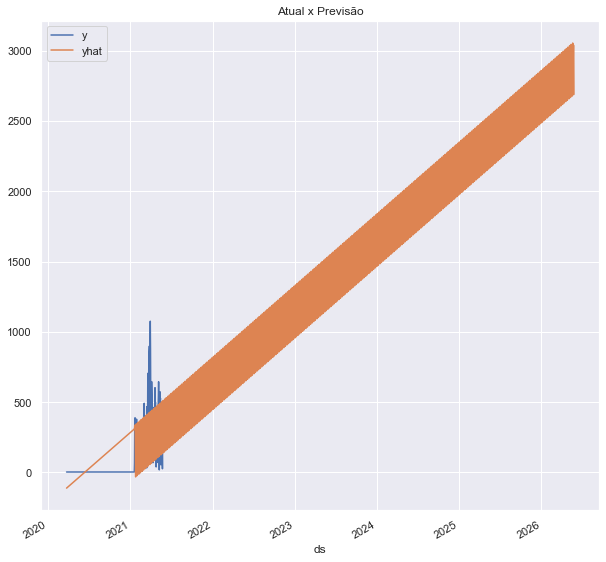

In [21]:
# Plotting o atual e os valores obtidos do Forecast:

ax = (df1.plot(x = 'ds', y = 'y',  figsize =(10,10), title = "Atual x Previsão"))
forecast.plot( x = 'ds', y ='yhat',figsize =(10,10), title = "Atual x Previsão", ax =ax )



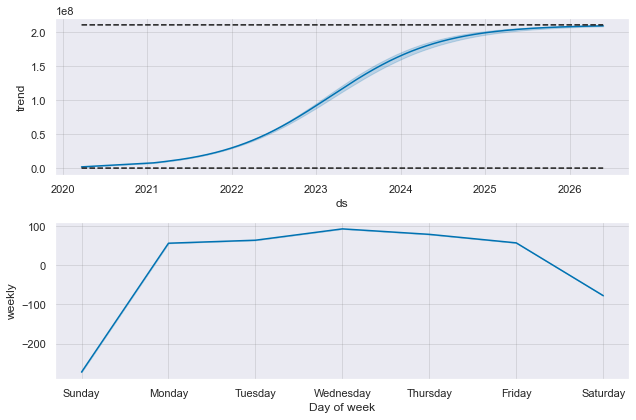

In [31]:
# Plotting os componentes Forecast:

fig2 = model.plot_components(forecast)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


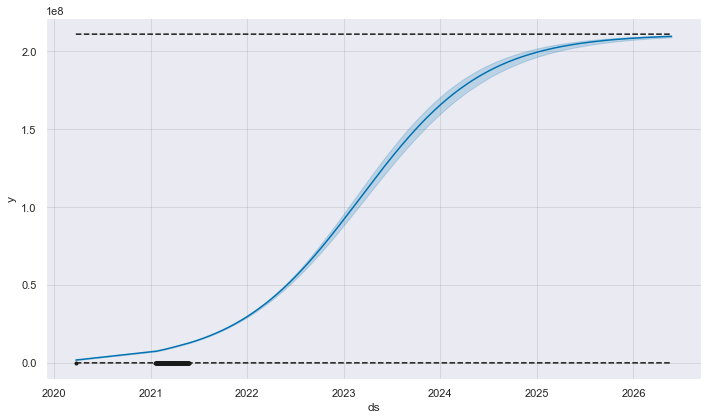

In [32]:
# Aqui faremos os ajustes para melhorar a nossa previsão:

# Prophet usa um modelo linear para sua previsão, e podemos usar um modelo de
# 1) A tendência de crescimento logística, 'growth = logistic'

# 2) Dois parâmetros são importantes no modelo:
# o parâmetro FLOOR = 0 ==> mínimo de saturação 
# o parâmetro CAP   =   ==> especifica o valor máximo, CAP = populacao brasileira

# 3) Parâmetro Trend, podemos ajustar a flexibilizar a tendência:

# Se as mudanças de tendência estão sendo super ajustadas (flexibilidade demais) ou insuficientes (flexibilidade insuficiente), você pode ajustar a força da dispersão antes de usar o argumento de entrada changepoint_prior_scale. 
# Por padrão, este parâmetro é definido como 0,05. 
# Aumentá-lo tornará a tendência mais flexível


# OBS: FLOOR e CAP devem ser especificados para CADA colunas do DataFrame, com
# valores mínimo e Máximo

df1['cap']  = 7000   # media vacinados por dia
df1['floor'] = 1      # valor do piso

model = Prophet(growth = 'logistic', changepoint_prior_scale = 0.5)  # define crescimento logistico
 
# Calculando fit:
model.fit(df1)

# Fazendo a previsão:

future        = model.make_future_dataframe(periods = 1826)
future['cap']   = 211000000
future['floor'] = 1
forecast = model.predict(future)

fig3 = model.plot(forecast)

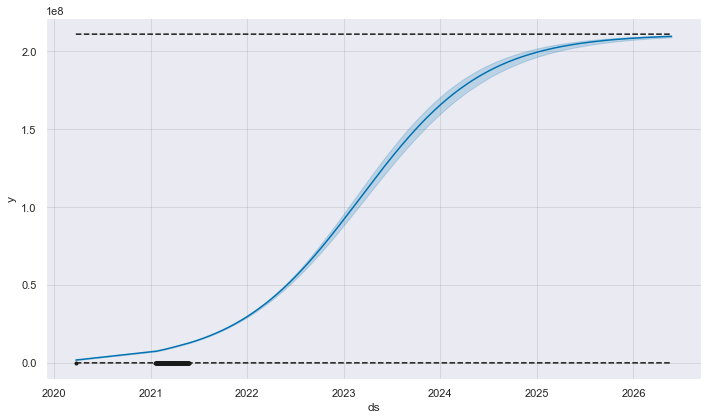

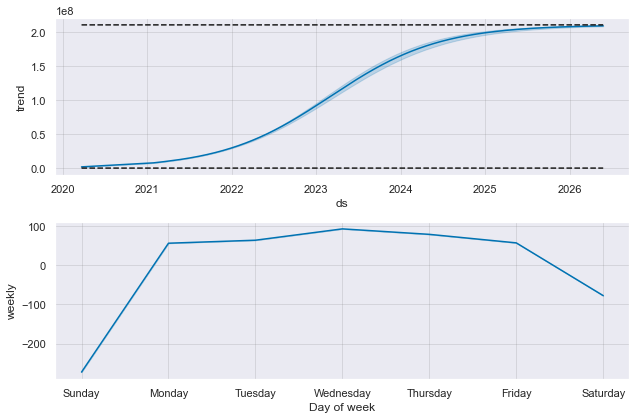

In [33]:
# Fazendo o Plotagem:

fig4 = model.plot(forecast, uncertainty = True)

fig5 = model.plot_components(forecast)

In [30]:
# Explicando as métricas:

# yhat: o valor previsto de nossa métrica (em Estatísticas, 
#       yhat é uma notação tradicionalmente usada para representar os valores previstos de um valor y)

# yhat_lower: o limite inferior de nossas previsões
# yhat_upper: o limite superior de nossas previsões


forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1950,2026-05-21,2.095731e+08,2.088824e+08,2.100426e+08
1951,2026-05-22,2.095791e+08,2.088901e+08,2.100472e+08
1952,2026-05-23,2.095849e+08,2.088977e+08,2.100513e+08
1953,2026-05-24,2.095907e+08,2.089058e+08,2.100556e+08
1954,2026-05-25,2.095970e+08,2.089136e+08,2.100601e+08


In [29]:
# Todos os campos da Previsão:

forecast

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-23,1.808632e+06,211000000,1,1.808471e+06,1.808901e+06,1.808632e+06,1.808632e+06,56.533368,56.533368,56.533368,56.533368,56.533368,56.533368,0.0,0.0,0.0,1.808689e+06
1,2021-01-18,7.369900e+06,211000000,1,7.369752e+06,7.370164e+06,7.369900e+06,7.369900e+06,56.533368,56.533368,56.533368,56.533368,56.533368,56.533368,0.0,0.0,0.0,7.369956e+06
2,2021-01-19,7.403807e+06,211000000,1,7.403668e+06,7.404072e+06,7.403807e+06,7.403807e+06,64.216802,64.216802,64.216802,64.216802,64.216802,64.216802,0.0,0.0,0.0,7.403871e+06
3,2021-01-20,7.437864e+06,211000000,1,7.437753e+06,7.438179e+06,7.437864e+06,7.437864e+06,93.208140,93.208140,93.208140,93.208140,93.208140,93.208140,0.0,0.0,0.0,7.437957e+06
4,2021-01-21,7.472073e+06,211000000,1,7.471922e+06,7.472363e+06,7.472073e+06,7.472073e+06,79.199781,79.199781,79.199781,79.199781,79.199781,79.199781,0.0,0.0,0.0,7.472152e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1950,2026-05-21,2.095730e+08,211000000,1,2.088824e+08,2.100426e+08,2.088823e+08,2.100426e+08,79.199781,79.199781,79.199781,79.199781,79.199781,79.199781,0.0,0.0,0.0,2.095731e+08
1951,2026-05-22,2.095790e+08,211000000,1,2.088901e+08,2.100472e+08,2.088901e+08,2.100470e+08,57.408127,57.408127,57.408127,57.408127,57.408127,57.408127,0.0,0.0,0.0,2.095791e+08
1952,2026-05-23,2.095850e+08,211000000,1,2.088977e+08,2.100513e+08,2.088980e+08,2.100514e+08,-77.497025,-77.497025,-77.497025,-77.497025,-77.497025,-77.497025,0.0,0.0,0.0,2.095849e+08
1953,2026-05-24,2.095910e+08,211000000,1,2.089058e+08,2.100556e+08,2.089058e+08,2.100559e+08,-273.069193,-273.069193,-273.069193,-273.069193,-273.069193,-273.069193,0.0,0.0,0.0,2.095907e+08


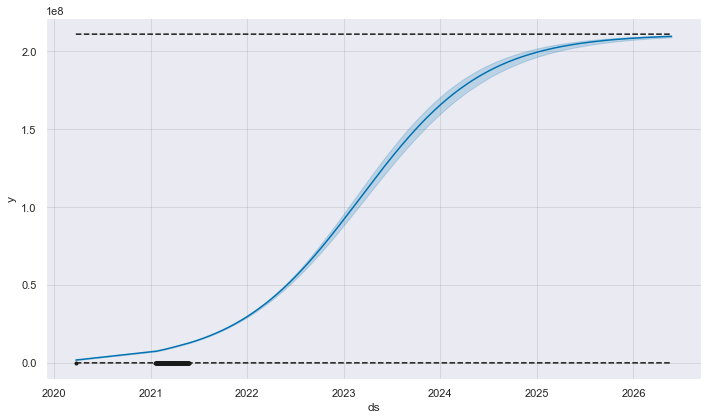

In [34]:
fig = model.plot(forecast)

<AxesSubplot:title={'center':'Atual X Futuro'}, xlabel='ds'>

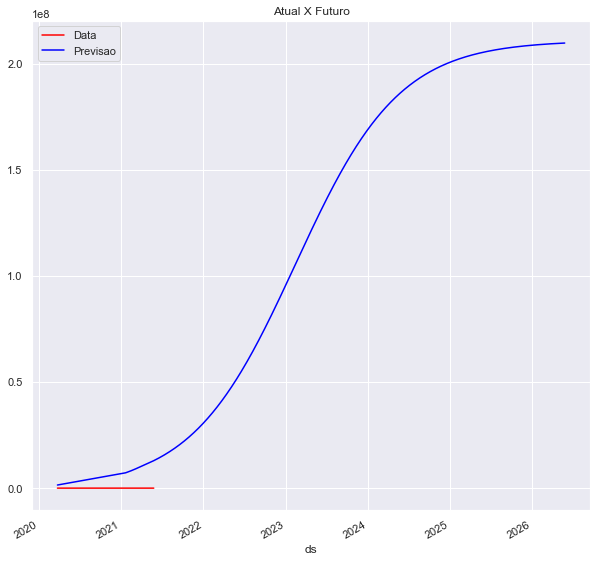

In [38]:
# plotting valores Atual e Futuro: 

ax = (df1.plot(x= 'ds', y = 'y',   legend = True, label = 'Data', figsize= (10,30), color = 'red')) 
forecast.plot(x= 'ds',  y ='yhat', legend = True, label = 'Previsao', figsize=(10,10),title='Atual X Futuro', color ='blue',ax=ax)



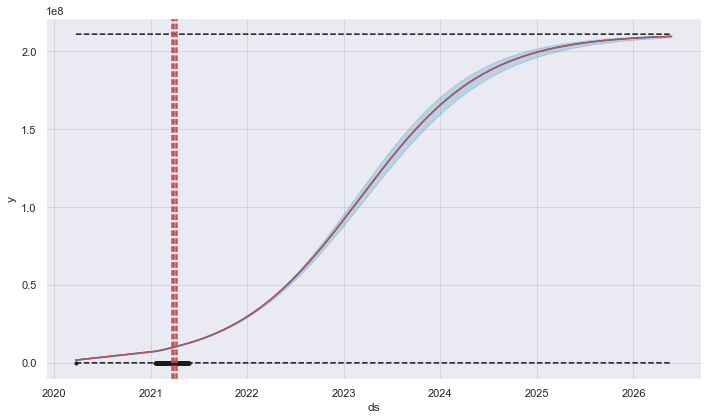

In [35]:
fig = model.plot(forecast)
a   = add_changepoints_to_plot(fig.gca(), model, forecast)

# Aqui estarei fazendo as Previsões da Segunda Dose da Vacina:

In [36]:
df2 = df.groupby('vacina_dataAplicacao').agg({'2a_dose':'sum'}).reset_index()

df2['vacina_dataAplicacao'].value_counts()


2021-03-17    1
2021-01-24    1
2021-03-27    1
2021-03-05    1
2021-03-19    1
             ..
2021-05-10    1
2021-01-30    1
2021-02-26    1
2021-04-16    1
2021-05-19    1
Name: vacina_dataAplicacao, Length: 129, dtype: int64

In [37]:
# Renomeando as colunas para preparar para rodar o Modelo Prophet:

df2.columns = ['ds', 'y']

In [38]:
df2

,ds,y
0,2020-03-23,0
1,2021-01-18,0
2,2021-01-19,1
3,2021-01-20,0
4,2021-01-21,0
...,...,...
124,2021-05-21,161
125,2021-05-22,95
126,2021-05-23,16
127,2021-05-24,164


<AxesSubplot:title={'center':'Datas Vacinação da 2. Dose'}, xlabel='ds'>

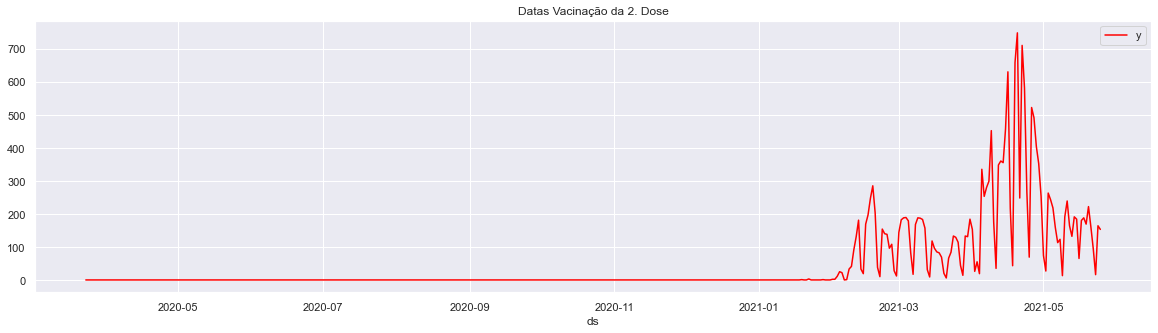

In [49]:
# Plotting Data Atual

df2.plot(x ='ds', y ='y', figsize = (20,5), title = 'Datas Vacinação da 2. Dose' , color = 'red')

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


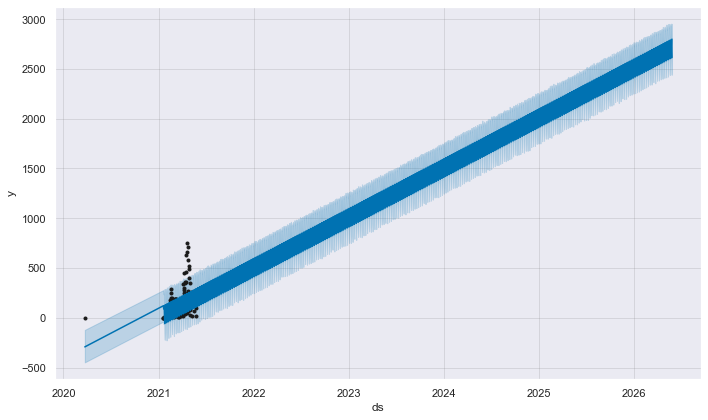

In [39]:
# Fazendo Saturações Previsões de Crescimento com Prophet sem nenhum parâmetros:

model = Prophet()

model.fit(df2)

future   = model.make_future_dataframe(periods = 1826)

forecast = model.predict(future)

fig1 = model.plot(forecast)


In [40]:
# Definindo a sazonalidade diaria, semanal e mensal terá mais controle sobre a sazonalidade. 

model = Prophet(daily_seasonality      = False,
               weekly_seasonality      = False,
               yearly_seasonality      = False,
               ).add_seasonality(name= 'mounthly',
                                 period = 30,
                                 fourier_order = 12
                ).add_seasonality(name = 'dayly',
                                 period = 1,
                                 fourier_order = 15
                                 ).add_seasonality(name = 'weekly',
                                 period = 7,
                                 fourier_order = 20,
                ).add_seasonality(name= 'yearly',
                                 period = 365.25,
                                 fourier_order = 20
                ).add_seasonality(name= 'quartely',
                                 period = 365.25/4,
                                 fourier_order = 5,
                                 prior_scale = 15)
                

# Rodando o Algorítmo de Previsao PROPHETS para '2a_dose' com Ajustes:

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


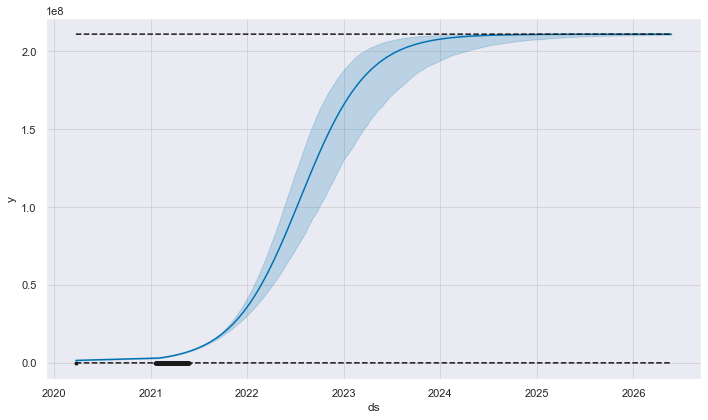

In [41]:
# Aqui faremos os ajustes para melhorar a nossa previsão:

# Prophet usa um modelo linear para sua previsão, e podemos usar um modelo de
# 1) A tendência de crescimento logística, 'growth = logistic'

# 2) Dois parâmetros são importantes no modelo:
# o parâmetro FLOOR = 0 ==> mínimo de saturação 
# o parâmetro CAP   =   ==> especifica o valor máximo, CAP = populacao brasileira

# 3) Parâmetro Trend, podemos ajustar a flexibilizar a tendência:

# Se as mudanças de tendência estão sendo super ajustadas (flexibilidade demais) ou insuficientes (flexibilidade insuficiente), você pode ajustar a força da dispersão antes de usar o argumento de entrada changepoint_prior_scale. 
# Por padrão, este parâmetro é definido como 0,05. 
# Aumentá-lo tornará a tendência mais flexível


# OBS: FLOOR e CAP devem ser especificados para CADA colunas do DataFrame, com
# valores mínimo e Máximo

df2['cap']  = 7000   # media vacinados por dia
df2['floor'] = 1      # valor do piso

model = Prophet(growth = 'logistic', changepoint_prior_scale = 0.5)  # define crescimento logistico
 
# Calculando fit:
model.fit(df2)

# Fazendo a previsão:

future          = model.make_future_dataframe(periods = 1826)
future['cap']   = 211000000
future['floor'] = 1
forecast = model.predict(future)

fig3 = model.plot(forecast)

In [42]:
# Explicando as métricas:

# yhat: o valor previsto de nossa métrica (em Estatísticas, 
#       yhat é uma notação tradicionalmente usada para representar os valores previstos de um valor y)

# yhat_lower: o limite inferior de nossas previsões
# yhat_upper: o limite superior de nossas previsões


forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1950,2026-05-21,2.109967e+08,2.106212e+08,2.110000e+08
1951,2026-05-22,2.109967e+08,2.106230e+08,2.110000e+08
1952,2026-05-23,2.109966e+08,2.106245e+08,2.109999e+08
1953,2026-05-24,2.109966e+08,2.106259e+08,2.109998e+08
1954,2026-05-25,2.109968e+08,2.106277e+08,2.110000e+08


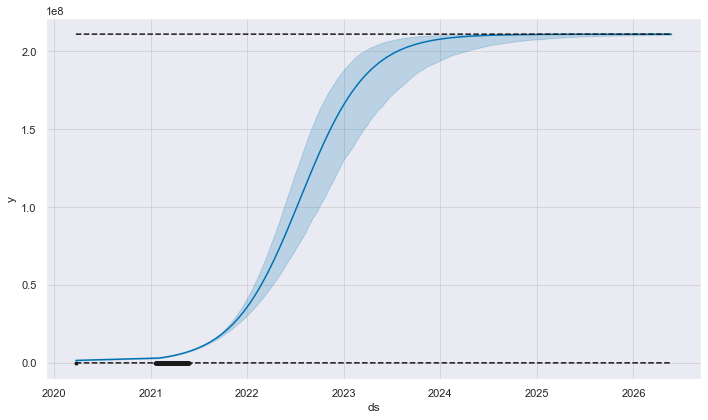

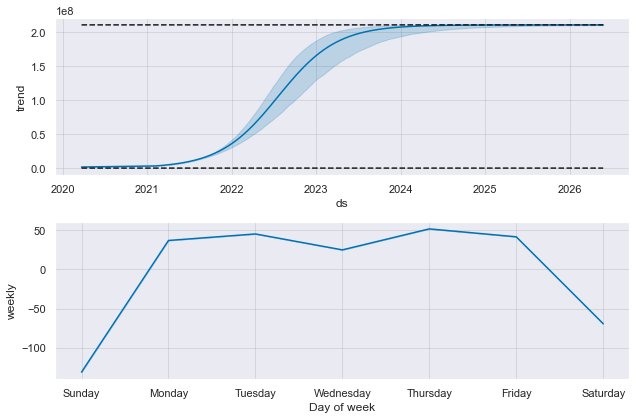

In [43]:
# Fazendo o Plotagem:

fig = model.plot(forecast)

fig = model.plot_components(forecast)